In [15]:
import matplotlib.pyplot as plt
import numpy as np

In [16]:
%matplotlib inline

## Some demo plots

In [17]:
prices = np.random.randint(10, 30, 36)
bid_curve_resolution = np.arange(5, 40, 5)

In [18]:
prices

array([21, 22, 27, 29, 25, 19, 20, 13, 19, 15, 29, 28, 12, 11, 24, 14, 23,
       14, 16, 11, 20, 18, 14, 23, 29, 19, 28, 12, 11, 13, 23, 23, 10, 15,
       23, 22])

(2.0, 38.0)

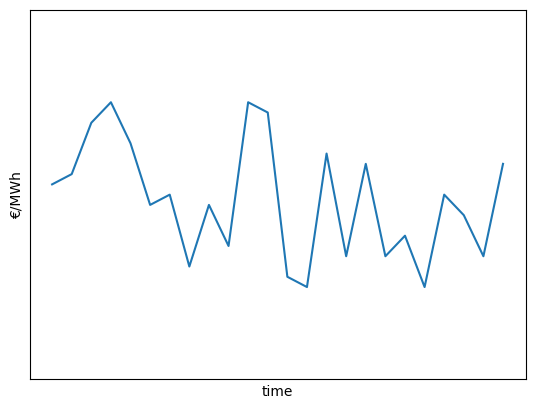

In [19]:
fig, ax = plt.subplots()
ax.plot(prices[:24])
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("time")
ax.set_ylabel("€/MWh")
ax.set_ylim([bid_curve_resolution[0] - 3, bid_curve_resolution[-1] + 3])

/tmp/ipykernel_627883/1882311821.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


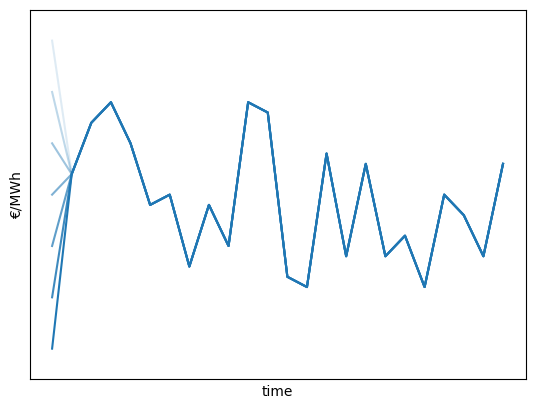

In [20]:
def plot_demo(prices, adjustments):
    """Screw."""
    fig, ax = plt.subplots()
    for i, adjustment in enumerate(adjustments):
        plot_prices = prices.copy()[:24]
        plot_prices[0] = adjustment
        ax.plot(plot_prices, c="C00", alpha=1 - i / len(adjustments))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("time")
    ax.set_ylabel("€/MWh")
    ax.set_ylim([bid_curve_resolution[0] - 3, bid_curve_resolution[-1] + 3])
    fig.show()


plot_demo(prices, bid_curve_resolution)

In [21]:
def plot_bids(demand_bids):
    """You."""
    qsum = 0
    x, y = [], []
    for q, p in demand_bids:
        if not q:
            continue
        y.append(p)
        x.append(qsum)
        qsum += q
        y.append(p)
        x.append(qsum)
    fig, ax = plt.subplots()
    ax.plot(x, y, label="bids")
    ax.set_ylim(bottom=0)
    # ax.legend(loc=0)
    ax.set_xlabel("Q")
    ax.set_ylabel("€")
    ax.set_xticks([])
    ax.set_yticks([])

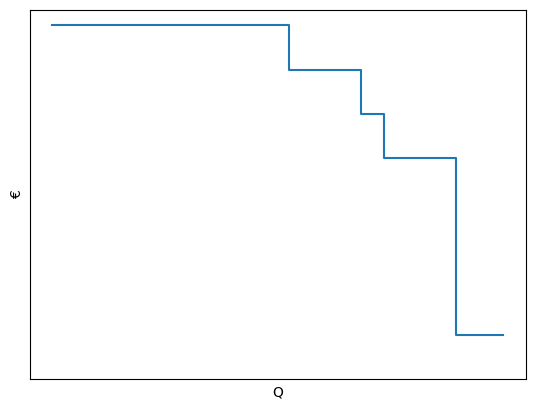

In [22]:
demand_bids = [(100, 40), (30, 35), (10, 30), (30, 25), (0, 15), (0, 10), (20, 5)]
plot_bids(demand_bids)

## Illustrating flexible energy store feasible region & initial store levels

In [25]:
from cronian.feasible_consumption import calculate_flex_store_bounds

In [26]:
n_hours_flexibility = 2
flex_demand = np.array([0, 0, 0, 0, 0, 5, 5, 10, 10, 20, 30, 25, 20, 10, 5, 5, 5, 0])

emin, emax = calculate_flex_store_bounds(f"flex+{n_hours_flexibility}", flex_demand)

In [27]:
emin, emax

(array([  0,   0,   0,   0,   0,   5,  10,  20,  30,  50,  80, 105, 125,
        135, 140, 145, 150, 150]),
 array([  0,   0,   0,   5,  10,  20,  30,  50,  80, 105, 125, 135, 140,
        145, 150, 150, 150, 150]))

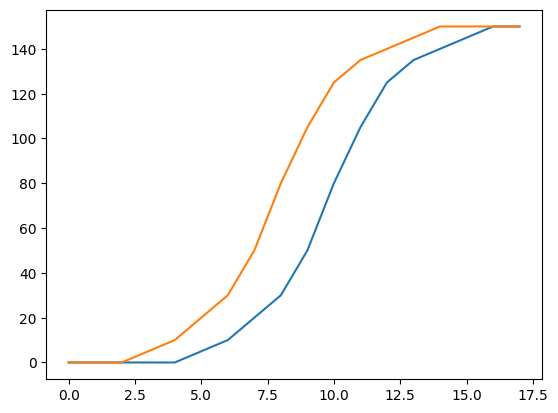

In [28]:
plt.plot(np.array([emin, emax]).T)

In [7]:
rng = np.random.default_rng(42)
store = rng.integers(emin, emax + 1).astype(float)
store.sort()
store

array([  0.,   0.,   0.,   0.,   8.,  15.,  19.,  33.,  54.,  73., 111.,
       112., 126., 140., 149., 150., 150., 150.])

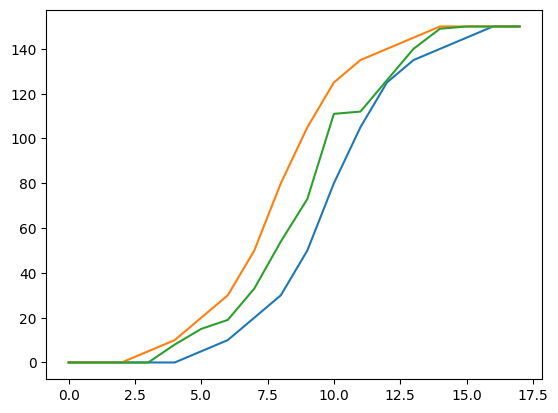

In [8]:
plt.plot(np.array([emin, emax, store]).T)

In [9]:
init_store = store.copy()
init_store[1:] -= init_store[:-1]

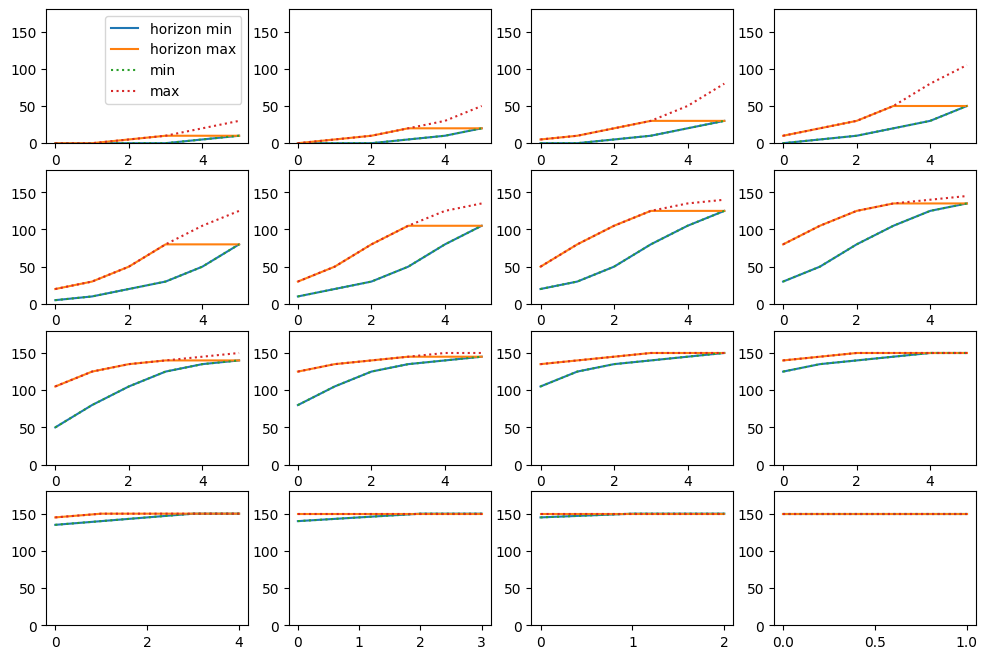

In [10]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 8))
horizon_length = 6

for idx, ax in enumerate(axes.flatten(), start=1):
    horizon_demand = flex_demand[idx : idx + horizon_length]

    horizon_min, horizon_max = calculate_flex_store_bounds(f"flex+{n_hours_flexibility}", horizon_demand)
    horizon_min += emin[idx - 1]
    horizon_max += emin[idx - 1]

    ax.set_ylim([0, 180])
    ax.plot(np.array([horizon_min, horizon_max]).T, label=["horizon min", "horizon max"])
    ax.plot(
        np.array([emin[idx : idx + horizon_length], emax[idx : idx + horizon_length]]).T,
        linestyle=":",
        label=["min", "max"],
    )
axes[0, 0].legend(loc=0)

what is the intuition here?
- moving right within a row...?
- what is the x axis? why do the values change in a given row? (if the rows mean anything)?

### Without taking initial store level into account

In [11]:
import matplotlib.patches as patches

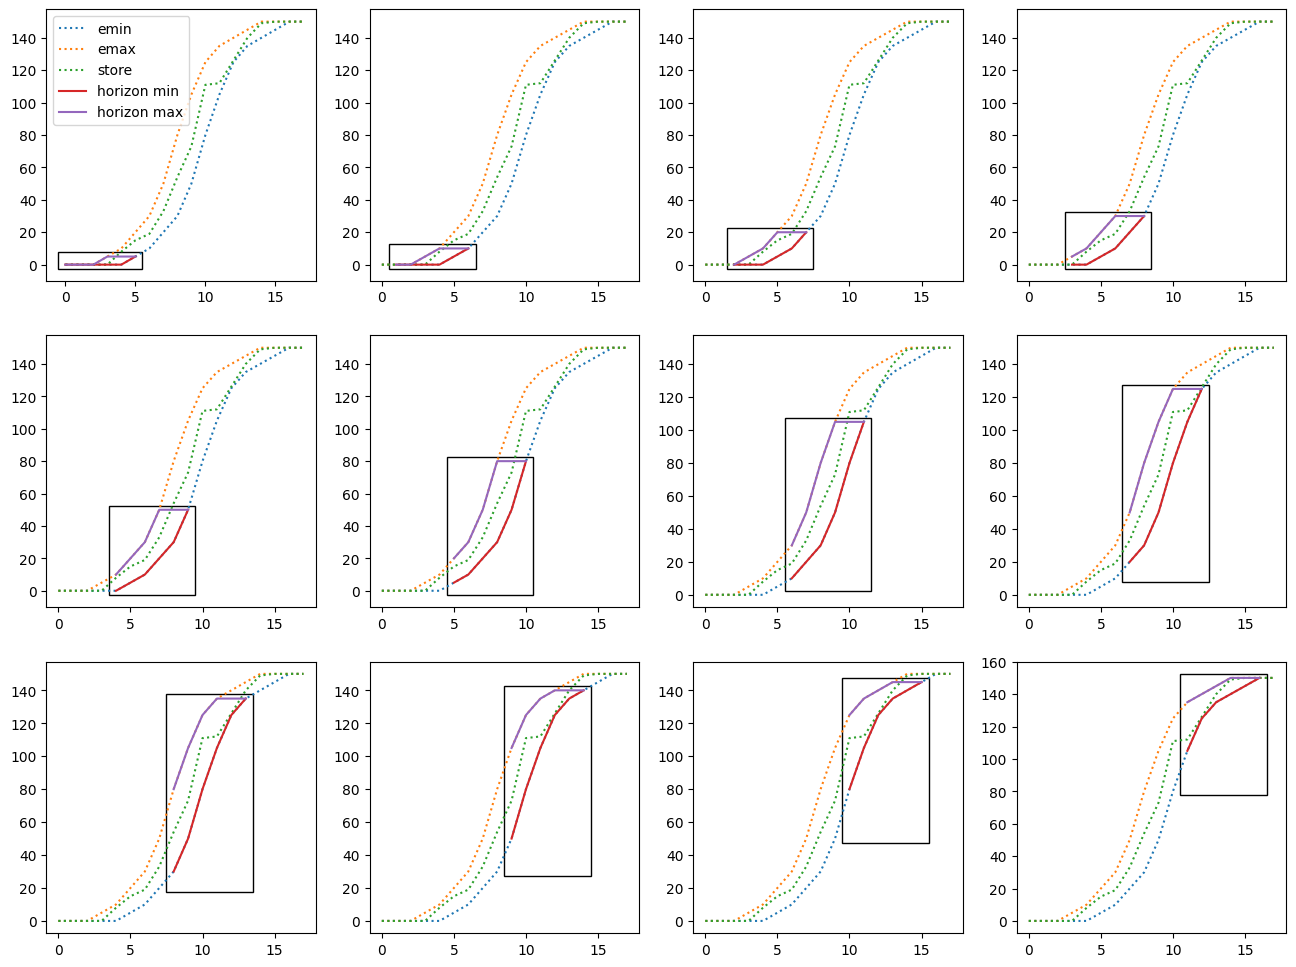

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))
horizon_length = 6

for idx, ax in enumerate(axes.flatten()):
    horizon_demand = flex_demand[idx : idx + horizon_length]
    horizon_min, horizon_max = calculate_flex_store_bounds(f"flex+{n_hours_flexibility}", horizon_demand)

    x_padding, y_padding = 0.5, 2.5

    box_x = idx
    box_y = 0 if idx == 0 else emin[idx - 1]
    box_height = horizon_min[-1]
    box_width = min(horizon_length - 1, len(emin) - idx - 1)

    ax.plot(np.array([emin, emax, store]).T, label=["emin", "emax", "store"], linestyle=":")
    ax.add_patch(
        patches.Rectangle(
            xy=[box_x - x_padding, box_y - y_padding],
            width=box_width + (2 * x_padding),
            height=box_height + (2 * y_padding),
            fill=False,
            edgecolor="black",
        )
    )

    horizon_min = horizon_min + box_y
    horizon_max = horizon_max + box_y
    horizon = range(idx, idx + horizon_length)
    ax.plot(horizon, np.array([horizon_min, horizon_max]).T, label=["horizon min", "horizon max"])
axes[0, 0].legend(loc=0)

Only considering the specific window is all fine and dandy since we know the entire timeseries for `emin` and `emax`.
However, note that to draw the `horizon_min` and `horizon_max` at the matching height, we had to adjust them:
```python
box_y = 0 if idx == 0 else emin[idx-1]
horizon_min += box_y
horizon_max += box_y
```

This would cause a problem if we only consider the specific window. In that case, the 'actual' view with the 0-point as determined by that horizon's feasibility region would be more like this:

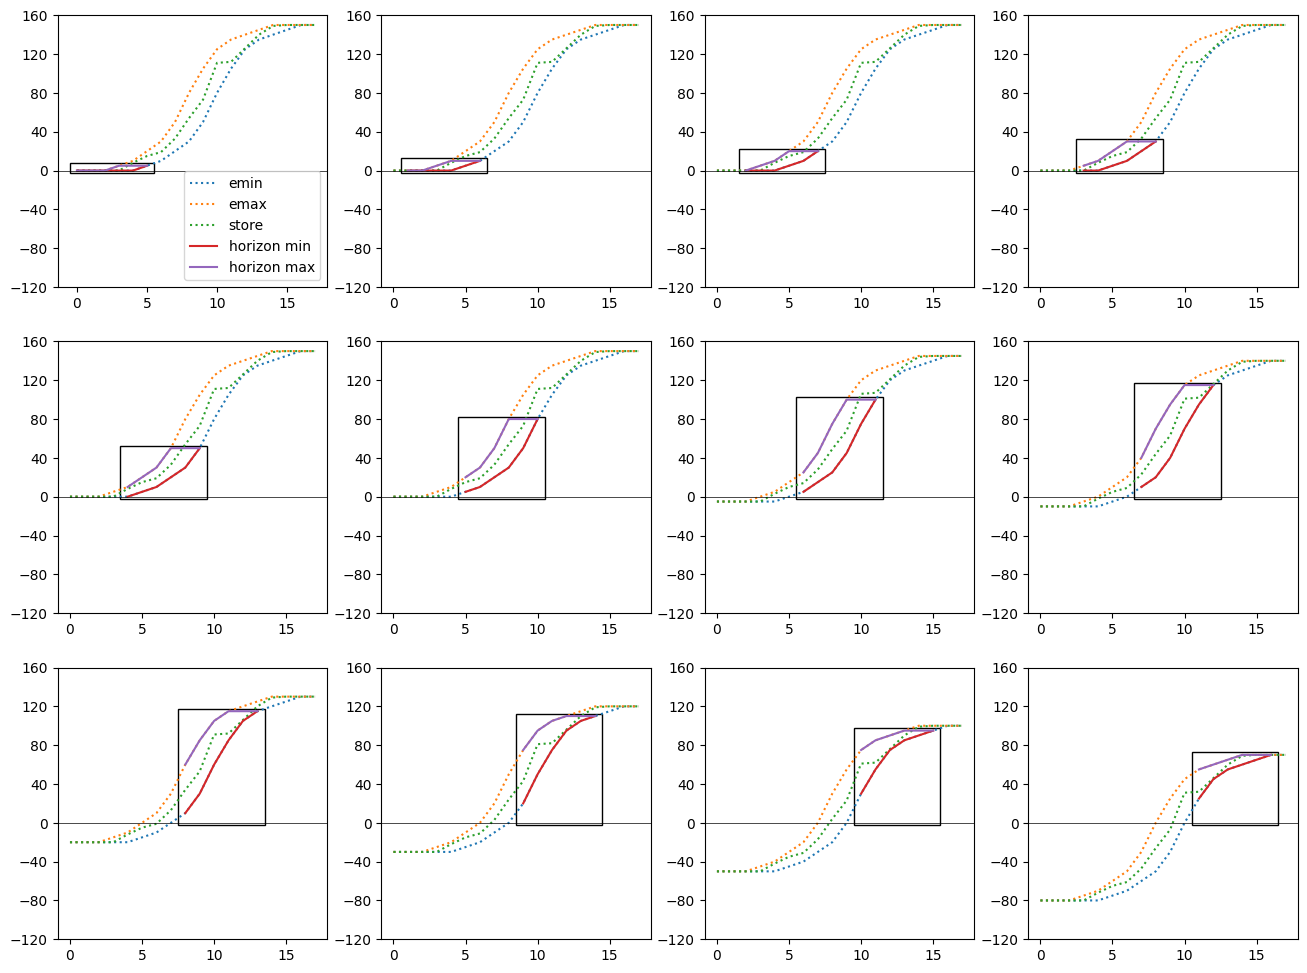

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))
horizon_length = 6

for idx, ax in enumerate(axes.flatten()):
    horizon_demand = flex_demand[idx : idx + horizon_length]
    horizon_min, horizon_max = calculate_flex_store_bounds(f"flex+{n_hours_flexibility}", horizon_demand)

    x_padding, y_padding = 0.5, 2.5

    box_x = idx
    box_y = 0
    box_height = horizon_min[-1]
    box_width = min(horizon_length - 1, len(emin) - idx - 1)

    y_offset = 0 if idx == 0 else emin[idx - 1]

    ax.plot(
        np.array([emin - y_offset, emax - y_offset, store - y_offset]).T, label=["emin", "emax", "store"], linestyle=":"
    )
    ax.add_patch(
        patches.Rectangle(
            xy=[box_x - x_padding, box_y - y_padding],
            width=box_width + (2 * x_padding),
            height=box_height + (2 * y_padding),
            fill=False,
            edgecolor="black",
        )
    )

    horizon = range(idx, idx + horizon_length)
    ax.plot(horizon, np.array([horizon_min, horizon_max]).T, label=["horizon min", "horizon max"])
    ax.set_ylim([-120, 160])
    ax.set_yticks([-120, -80, -40, 0, 40, 80, 120, 160])
    ax.axhline(color="black", linewidth=0.5)
axes[0, 0].legend(loc=0)

Still fine, until we start wanting to include an initial store level...

### Adjusting horizon view/store minimum by initial store level

Now if we want to include an initial store level, this means we want to adjust the minimum bound of the feasible region to be at least at the given store level.
This ensures that the next window we look at already takes into account any flexible demand that has already been satisfied in previous steps.
Leaving out the anchoring of the window at `y=0`, that looks as follows, with the dotted horizontal line indicating where the `y=0` level for the initial store level adjusted feasible region would be:

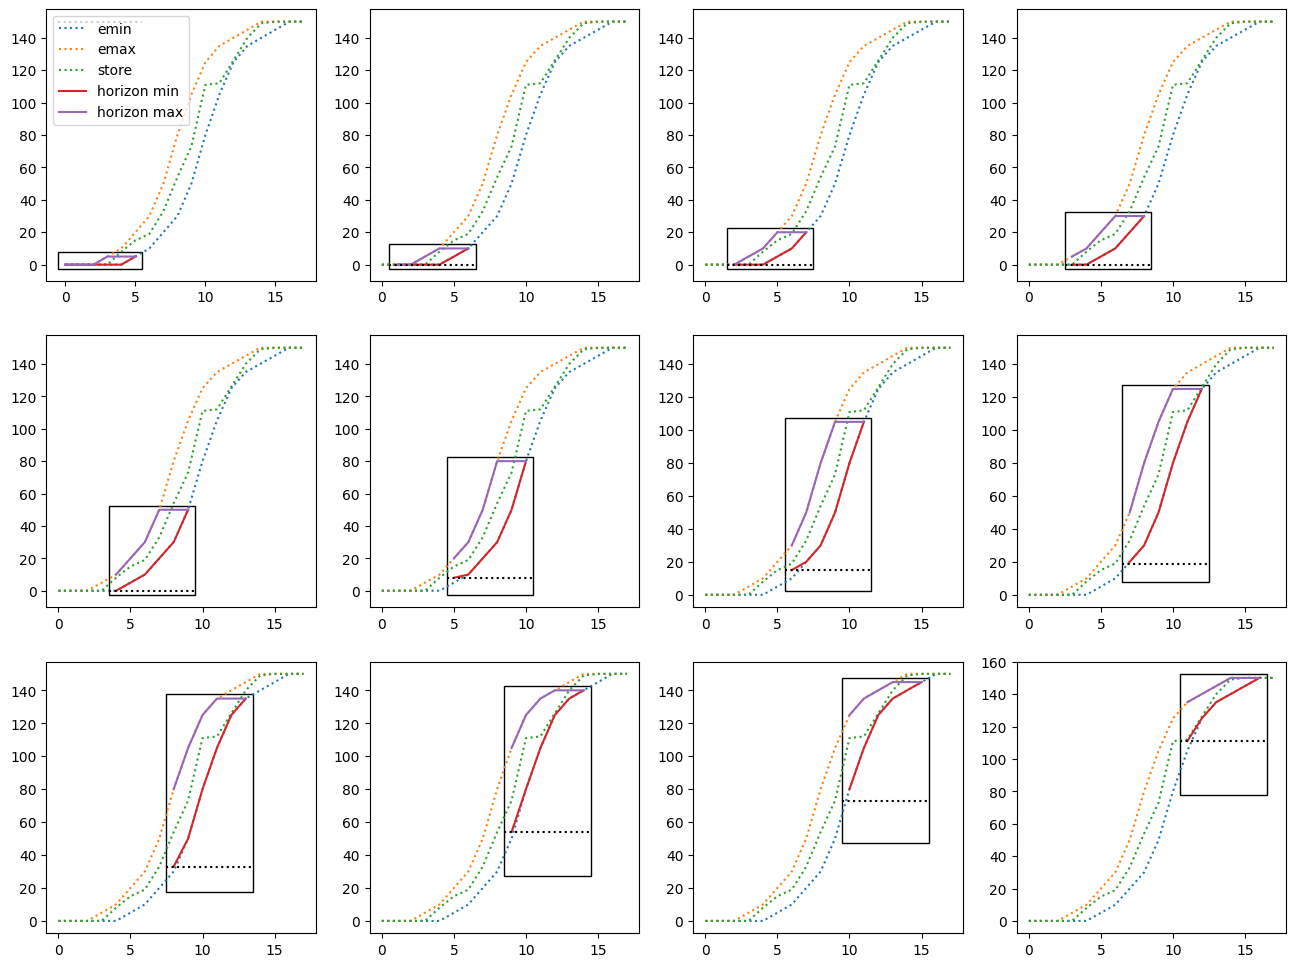

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))
horizon_length = 6

for idx, ax in enumerate(axes.flatten()):
    horizon_demand = flex_demand[idx : idx + horizon_length]
    horizon_min, horizon_max = calculate_flex_store_bounds(f"flex+{n_hours_flexibility}", horizon_demand)

    x_padding, y_padding = 0.5, 2.5

    box_x = idx
    box_y = 0 if idx == 0 else emin[idx - 1]
    box_height = horizon_min[-1]
    box_width = min(horizon_length - 1, len(emin) - idx - 1)
    store_idx = idx - 1 if idx > 0 else 0

    ax.plot(np.array([emin, emax, store]).T, label=["emin", "emax", "store"], linestyle=":")
    ax.add_patch(
        patches.Rectangle(
            xy=[box_x - x_padding, box_y - y_padding],
            width=box_width + (2 * x_padding),
            height=box_height + (2 * y_padding),
            fill=False,
            edgecolor="black",
        )
    )

    horizon_min += box_y
    horizon_max += box_y

    horizon_min[horizon_min < store[store_idx]] = store[store_idx]

    horizon = range(idx, idx + horizon_length)
    ax.plot(horizon, np.array([horizon_min, horizon_max]).T, label=["horizon min", "horizon max"])
    ax.hlines(store[idx - 1], box_x - x_padding, box_x + box_width + (x_padding), linestyle=":", color="black")
axes[0, 0].legend(loc=0)

We can easily do the shift down if we have access to the full `emin`/`emax` data, but the question is how to reach this same result by only considering the values we can know at any two consecutive windows.
Here's the result we're looking for:

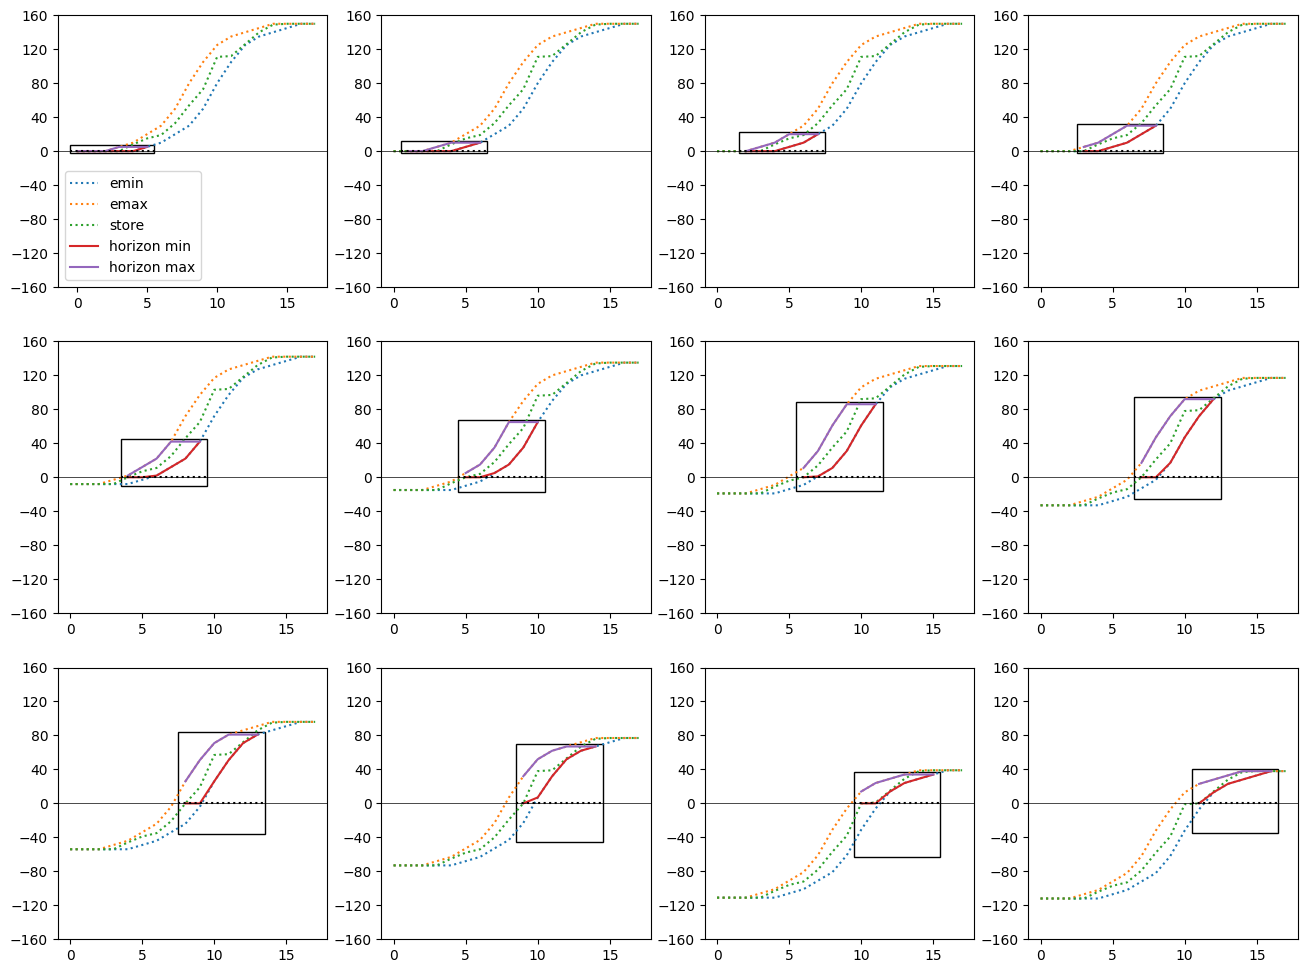

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))
horizon_length = 6

to_determine = []

for idx, ax in enumerate(axes.flatten()):
    horizon_demand = flex_demand[idx : idx + horizon_length]
    horizon_min, horizon_max = calculate_flex_store_bounds(f"flex+{n_hours_flexibility}", horizon_demand)

    x_padding, y_padding = 0.5, 2.5

    global_y_offset = 0 if idx == 0 else emin[idx - 1]  # Step 0: adjust 'global' data to match horizon window
    horizon_y_offset = store[idx] - global_y_offset  # Step 1: adjust to take 'initial store level' into account

    box_x = idx
    box_y = -horizon_y_offset
    box_height = horizon_min[-1]
    box_width = min(horizon_length - 1, len(emin) - idx - 1)

    to_determine.append(int(horizon_y_offset))

    ax.plot(
        np.array(
            [
                emin - global_y_offset - horizon_y_offset,
                emax - global_y_offset - horizon_y_offset,
                store - global_y_offset - horizon_y_offset,
            ]
        ).T,
        label=["emin", "emax", "store"],
        linestyle=":",
    )
    # ax.scatter(range(len(emin)), emin-global_y_offset-horizon_y_offset)
    ax.add_patch(
        patches.Rectangle(
            xy=[box_x - x_padding, box_y - y_padding],
            width=box_width + (2 * x_padding),
            height=box_height + (2 * y_padding),
            fill=False,
            edgecolor="black",
        )
    )

    horizon_min = horizon_min - horizon_y_offset
    horizon_max = horizon_max - horizon_y_offset
    horizon_min[horizon_min < 0] = 0

    horizon = range(idx, idx + horizon_length)
    ax.plot(horizon, np.array([horizon_min, horizon_max]).T, label=["horizon min", "horizon max"])
    ax.set_ylim([-160, 160])
    ax.set_yticks([-160, -120, -80, -40, 0, 40, 80, 120, 160])
    ax.hlines(0, box_x - x_padding, box_x + box_width + (x_padding), linestyle=":", color="black")
    ax.axhline(color="black", linewidth=0.5)
axes[0, 0].legend(loc=0)

In [19]:
mindiff = emin[1:] - emin[:-1]

allstore = store.astype(int)

print(f"{mindiff   =}")
print(f"{allstore  =}")
print(f"{init_store=}")
print(f"{to_determine=}")

print(f"{allstore[1:] - emin[:-1]=}")

mindiff   =array([ 0,  0,  0,  0,  5,  5, 10, 10, 20, 30, 25, 20, 10,  5,  5,  5,  0])
allstore  =array([  0,   0,   0,   0,   8,  15,  19,  33,  54,  73, 111, 112, 126,
       140, 149, 150, 150, 150])
init_store=array([ 0.,  0.,  0.,  0.,  8.,  7.,  4., 14., 21., 19., 38.,  1., 14.,
       14.,  9.,  1.,  0.,  0.])
to_determine=[0, 0, 0, 0, 8, 15, 14, 23, 34, 43, 61, 32]
allstore[1:] - emin[:-1]=array([ 0,  0,  0,  8, 15, 14, 23, 34, 43, 61, 32, 21, 15, 14, 10,  5,  0])
